In [3]:
import pandas as pd

# --- 1. CONFIGURAZIONE E CARICAMENTO ---
# Definiamo il percorso del file. Se il file è nella stessa cartella dello script, basta il nome.
file_path = 'data/train/training_data.csv'

print(f"Sto caricando il file da: {file_path}...")
df = pd.read_csv(file_path)
print("Caricamento completato!")

# --- 2. ORDINAMENTO TEMPORALE (CRUCIALE) ---
# I dati grezzi potrebbero non essere sequenziali. 
# Per fare prognostica, dobbiamo garantire che la riga N venga prima della riga N+1 nel tempo.
# Ordiniamo per:
# 1. ESN (Numero Motore): Per non mischiare i dati del motore 101 con il 102.
# 2. Cycles_Since_New (Età): Per mettere in fila i voli dal primo all'ultimo.
# 3. Snapshot (Istante): Per mettere in ordine gli scatti all'interno dello stesso volo.
df = df.sort_values(by=['ESN', 'Cycles_Since_New', 'Snapshot'])

# Resettiamo l'indice per avere una numerazione pulita delle righe (0, 1, 2...)
df = df.reset_index(drop=True)

# --- 3. ISPEZIONE DEI DATI ---
print("\n--- INFO GENERALE DATASET ---")
# .info() è utilissimo: ci dice quante righe totali abbiamo e il tipo di dati.
df.info()

print("\n--- ANTEPRIMA (PRIME 5 RIGHE) ---")
# Vediamo concretamente come sono fatti i dati
print(df.head())

# --- 4. CONTROLLO QUALITÀ DATI (MISSING VALUES) ---
print("\n--- CONTEGGIO VALORI MANCANTI (NaN) ---")
# Contiamo quanti dati mancano per ogni colonna.
# Se vedi numeri > 0 qui, dovrai gestire questi buchi nella fase di pulizia.
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0]) # Stampa solo le colonne che hanno problemi

Sto caricando il file da: data/train/training_data.csv...
Caricamento completato!

--- INFO GENERALE DATASET ---
<class 'pandas.DataFrame'>
RangeIndex: 59702 entries, 0 to 59701
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ESN                 59702 non-null  int64  
 1   Cycles_Since_New    59702 non-null  int64  
 2   Snapshot            59702 non-null  int64  
 3   Cumulative_WWs      59702 non-null  int64  
 4   Cumulative_HPC_SVs  59702 non-null  int64  
 5   Cumulative_HPT_SVs  59702 non-null  int64  
 6   Sensed_Altitude     59702 non-null  float64
 7   Sensed_Mach         59702 non-null  float64
 8   Sensed_Pamb         59702 non-null  float64
 9   Sensed_Pt2          59702 non-null  float64
 10  Sensed_TAT          59702 non-null  float64
 11  Sensed_WFuel        59005 non-null  float64
 12  Sensed_VAFN         59702 non-null  float64
 13  Sensed_VBV          59702 non-null  float64
 14  

In [4]:
#--
print("Analisi snapshot")

# Count ci dice quante righe (snapshot) ci sono per ogni volo
snapshot_counts = df.groupby(['ESN', 'Cycles_Since_New'])['Snapshot'].count()

# 2. Statistiche di base
max_snap = snapshot_counts.max()
min_snap = snapshot_counts.min()
print(f"Max snapshot per volo: {max_snap}")
print(f"Min snapshot per volo: {min_snap}")

# 3. Vediamo la distribuzione
# Ci dice: "Ci sono X voli con 8 snapshot, Y voli con 7 snapshot..."
print("\nDistribuzione frequenza snapshot:")
print(snapshot_counts.value_counts().sort_index())

# 4. Identificazione dei voli con "buchi" (Gaps)
# Esempio: ho snapshot 1, 2, 4 -> Manca il 3. Questo codice lo trova.
def has_gap(series):
    # Crea un set dei numeri attesi (dal minimo al massimo trovati in quel volo)
    expected = set(range(series.min(), series.max() + 1))
    actual = set(series)
    # Se la differenza tra i due set non è vuota, manca qualcosa
    return len(expected - actual) > 0

# Applichiamo la funzione a tutti i voli (può richiedere qualche secondo)
gaps = df.groupby(['ESN', 'Cycles_Since_New'])['Snapshot'].apply(has_gap)
num_gaps = gaps[gaps == True].count()

print(f"\nNumero di voli con sequenza snapshot interrotta (buchi): {num_gaps}")

if num_gaps > 0:
    print("Esempio di volo con buchi:")
    # Prendiamo il primo caso trovato
    example_idx = gaps[gaps == True].index[0] 
    print(f"Motore {example_idx[0]}, Volo {example_idx[1]}")
    print(df[(df['ESN'] == example_idx[0]) & (df['Cycles_Since_New'] == example_idx[1])][['Snapshot', 'Sensed_Altitude']])

Analisi snapshot
Max snapshot per volo: 8
Min snapshot per volo: 7

Distribuzione frequenza snapshot:
Snapshot
7    4330
8    3674
Name: count, dtype: int64

Numero di voli con sequenza snapshot interrotta (buchi): 4330
Esempio di volo con buchi:
Motore 101, Volo 0
   Snapshot  Sensed_Altitude
0         1       851.321516
1         2       903.321516
2         3      3410.321516
3         4     20259.321516
4         6     21991.321516
5         7     21997.321516
6         8     21996.321516


In [5]:
# STRATEGIA Crociera stabile ---
# Definiamo una soglia di altitudine per considerare l'aereo in "Crociera".
ALTITUDE_THRESHOLD = 20000 

print(f"Dataset originale: {df.shape} righe (snapshot singoli)")

# 2. Filtraggio: Teniamo solo i dati in quota
# Creiamo una maschera booleana: teniamo solo le righe dove l'altitudine è > 20000
cruise_mask = df['Sensed_Altitude'] > ALTITUDE_THRESHOLD
df_cruise = df[cruise_mask].copy()

print(f"Dataset filtrato (solo quota > {ALTITUDE_THRESHOLD}): {df_cruise.shape} righe")


# Dobbiamo comprimere i vari snapshot in una sola riga per volo.
# Ma non tutte le colonne si trattano allo stesso modo!

# A) COLONNE SENSORI
# Vogliamo la MEDIA (mean). Perché? Perché riduce il rumore di lettura dei sensori.
sensor_cols = [c for c in df.columns if 'Sensed_' in c]

# B) COLONNE TARGET  
# Queste non cambiano durante il volo. Se mancano 100 cicli all'inizio del volo, ne mancano 100 anche alla fine.
# Usiamo 'first' (prendi il primo valore che trovi).
target_cols = ['Cycles_to_WW', 'Cycles_to_HPC_SV', 'Cycles_to_HPT_SV']

# C) METADATI (Cumulative_...):
# Contatori cumulativi. Usiamo 'max' per sicurezza (prendiamo il valore più alto registrato nel volo).
meta_cols = ['Cumulative_WWs', 'Cumulative_HPC_SVs', 'Cumulative_HPT_SVs']

# Creiamo il dizionario che dice a Pandas cosa fare per ogni colonna
agg_dict = {}
for col in sensor_cols:
    agg_dict[col] = 'mean'
for col in target_cols:
    agg_dict[col] = 'first'
for col in meta_cols:
    agg_dict[col] = 'max'

# 4. Aggregazione (Il cuore della strategia)
# Raggruppiamo per 'ESN' (Motore) e 'Cycles_Since_New' (Età/Volo)
# Questo comando schiaccia tutte le righe dello stesso volo in una sola, applicando le regole sopra.
df_grouped = df_cruise.groupby(['ESN', 'Cycles_Since_New']).agg(agg_dict).reset_index()

# 5. Risultato Finale
print(f"Dataset finale aggregato: {df_grouped.shape} righe (una per volo)")

# Salviamo il file pulito per usarlo nei prossimi passaggi
df_grouped.to_csv('training_data_cleaned.csv', index=False)
print("File 'training_data_cleaned.csv' salvato con successo.")

Dataset originale: (59702, 25) righe (snapshot singoli)
Dataset filtrato (solo quota > 20000): (36253, 25) righe
Dataset finale aggregato: (7845, 24) righe (una per volo)
File 'training_data_cleaned.csv' salvato con successo.


In [ ]:
# 4. Stampa Output
# Usiamo to_string() per forzare Python a stampare tutte le colonne senza tagliarle
print("--- ANTEPRIMA TABELLA AGGREGATA (15 righe) ---")
print(df_grouped.head(15).to_string())

print("\nESEMPIO MOTORE ESN 102")
print(df_grouped[df_grouped['ESN'] == 102].head(5).to_string())

--- ANTEPRIMA TABELLA AGGREGATA (Prime 15 righe) ---
    ESN  Cycles_Since_New  Sensed_Altitude  Sensed_Mach  Sensed_Pamb  Sensed_Pt2  Sensed_TAT  Sensed_WFuel  Sensed_VAFN  Sensed_VBV  Sensed_Fan_Speed  Sensed_Core_Speed  Sensed_T25    Sensed_T3  Sensed_Ps3   Sensed_T45  Sensed_P25    Sensed_T5  Cycles_to_WW  Cycles_to_HPC_SV  Cycles_to_HPT_SV  Cumulative_WWs  Cumulative_HPC_SVs  Cumulative_HPT_SVs
0   101                 0     21561.071516     0.624281     6.342453    8.222654  495.289555      0.554608  4484.591786    0.009658       1732.762805       19978.130319  683.653541  1440.268613  238.846836  1910.568924   22.419295  1215.706083           910              8510              4090               0                   0                   0
1   101                10     24517.821516     0.663877     5.607710    7.495710  497.792314      0.574313  4518.625303    0.000000       1833.229898       20334.107114  703.055003  1488.234013  239.539026  1993.571117   22.035035  1242.192320    

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [9]:
def process_dataset(df):
    """
    Trasforma il dataset grezzo in uno pulito (Cruise Only).
    Si adatta dinamicamente alle colonne presenti.
    """
    print(f"   -> Processing {df.shape[0]} righe grezze...")
    
    # 1. Filtro Altitudine (Solo se la colonna esiste)
    if 'Sensed_Altitude' in df.columns:
        ALTITUDE_THRESHOLD = 20000 
        cruise_mask = df['Sensed_Altitude'] > ALTITUDE_THRESHOLD
        df_cruise = df[cruise_mask].copy()
    else:
        df_cruise = df.copy() # Se manca l'altitudine, usiamo tutto
    
    # 2. Definizione Regole di Aggregazione DINAMICA
    # Cerchiamo le colonne che ESISTONO DAVVERO nel dataframe attuale
    sensor_cols = [c for c in df.columns if 'Sensed_' in c]
    
    potential_meta = ['Cumulative_WWs', 'Cumulative_HPC_SVs', 'Cumulative_HPT_SVs']
    meta_cols = [c for c in potential_meta if c in df.columns] # <--- FIX CRUCIALE
    
    potential_targets = ['Cycles_to_HPC_SV', 'Cycles_to_HPT_SV', 'Cycles_to_WW']
    target_cols = [c for c in potential_targets if c in df.columns] # <--- FIX CRUCIALE

    agg_dict = {}
    for col in sensor_cols: agg_dict[col] = 'mean'
    for col in meta_cols: agg_dict[col] = 'max'
    for col in target_cols: agg_dict[col] = 'first'
    
    # 3. Aggregazione
    # Verifica che le chiavi di raggruppamento esistano
    if 'ESN' in df_cruise.columns and 'Cycles_Since_New' in df_cruise.columns:
        df_grouped = df_cruise.groupby(['ESN', 'Cycles_Since_New']).agg(agg_dict).reset_index()
        print(f"   -> Risultato: {df_grouped.shape[0]} voli (righe) pronti.")
        return df_grouped
    else:
        print("ERRORE: Colonne ESN o Cycles_Since_New mancanti.")
        return pd.DataFrame()

In [10]:
# ==============================================================================
# 2. FUNZIONI DI SCORING (METRICA UFFICIALE PHM)
# ==============================================================================


def time_weighted_error(y_true, y_pred, alpha=0.02, beta=1):
    """Calcola l'errore pesato asimmetrico per singola predizione."""
    error = y_pred - y_true
    # Se error >= 0 (Predizione Tardiva/Late): Penalità doppia
    # Se error < 0 (Predizione Anticipata/Early): Penalità standard
    weight = np.where(
        error >= 0,
        2 / (1 + alpha * y_true),
        1 / (1 + alpha * y_true)
    )
    return weight * (error ** 2) * beta

def get_official_score(y_true, y_pred, component_type):
    """Calcola lo score medio in base al componente (HPT, HPC, WW)."""
    alpha = 0.01  # Fisso da regolamento
    
    # Il Beta cambia in base al massimo ciclo teorico del componente
    max_val = np.max(y_true)
    if max_val == 0: max_val = 1 # Evita divisione per zero
    
    if component_type == 'WW':
        beta = 1 / float(max_val)
    else:
        # HPT e HPC hanno beta pesato x2
        beta = 2 / float(max_val)
        
    scores = time_weighted_error(y_true, y_pred, alpha, beta)
    return np.mean(scores)

# ==============================================================================
# 3. MAIN SCRIPT
# ==============================================================================
def main():
    # --- A. CARICAMENTO DATI ---
    print("caricamento dati di training")
    try:
        df_train_raw = pd.read_csv('data/train/training_data.csv')
        
        print("File di training caricati con successo.")
    except FileNotFoundError as e:
        print(f"ERRORE: Non trovo i file. Assicurati che training_data.csv e validation_data.csv siano nella cartella.\n{e}")
        return
    
    print("caricamento dati di validation")
    path_validation = "data/val/*.csv" 

    # Trova tutti i file che corrispondono al pattern
    all_files = glob.glob(path_validation)

    if len(all_files) == 0:
        print(f"ERRORE: Non ho trovato nessun file csv nel percorso: {path_validation}")
        exit()

    print(f"Trovati {len(all_files)} file di validazione. Unione in corso...")

    # Legge ogni file e lo aggiunge a una lista
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    # Unisce tutto in un unico DataFrame
    df_val_raw = pd.concat(li, axis=0, ignore_index=True)

    print(f"Validation set unito caricato: {df_val_raw.shape} righe.")

    # --- C. FIX NOMI COLONNE (CRUCIALE) ---
    # Rinominiamo la colonna 'Cycles' in 'Cycles_Since_New' nel validation set
    if 'Cycles' in df_val_raw.columns and 'Cycles_Since_New' not in df_val_raw.columns:
        print("\n[FIX] Rinomino colonna 'Cycles' -> 'Cycles_Since_New' nel Validation Set...")
        df_val_raw.rename(columns={'Cycles': 'Cycles_Since_New'}, inplace=True)
    
    
    # --- B. PREPROCESSING ---
    print("\n--- 2. PREPROCESSING (CRUISE ONLY) ---")
    print("Processando Training Set:")
    df_train = process_dataset(df_train_raw)
    
    print("Processando Validation Set:")
    df_val = process_dataset(df_val_raw)

    if df_val.empty: return

    # --- C. PREPARAZIONE FEATURES (X) E TARGET (Y) ---
    
    # Usiamo SOLO le feature presenti in entrambi i dataset
    train_cols = set(df_train.columns)
    val_cols = set(df_val.columns)

    # Cerchiamo colonne che iniziano con Sensed_ o Cumulative_ che siano in ENTRAMBI
    potential_features = [c for c in train_cols if 'Sensed_' in c or 'Cumulative_' in c]
    features = [c for c in potential_features if c in val_cols]
    
    print(f"\nFeature selezionate ({len(features)}):")
    print(features)
    
    if len(features) == 0:
        print("ERRORE CRITICO: Non ci sono feature in comune tra Training e Validation!")
        return

    # --- F. ADDESTRAMENTO E PREDIZIONE ---
    X_train = df_train[features]
    X_val = df_val[features]
    
    # Target da predire (quelli presenti nel training)
    targets_train = ['Cycles_to_HPT_SV', 'Cycles_to_HPC_SV', 'Cycles_to_WW']
    targets_train = [t for t in targets_train if t in df_train.columns]
    
    # DataFrame per salvare i risultati
    results_df = df_val[['ESN', 'Cycles_Since_New']].copy()
    
    print("\n--- 4. ADDESTRAMENTO MODELLI ---")
    
    # [AGGIUNTA] Dizionario per salvare i dati per i grafici
    results = {} 

    for target in targets_train:
        print(f"Training su: {target} ...")
        
        # ... (il tuo codice di training e fit rimane uguale) ...
        model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
        model.fit(X_train, df_train[target])
        
        # Predizione
        y_pred = model.predict(X_val)
        results_df[target] = y_pred 
        
        # --- MODIFICA QUI SOTTO ---
        # Valutazione e Salvataggio dati per Grafico
        if target in df_val.columns:
            y_true = df_val[target]
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            # Calcolo score (se serve per il titolo del grafico)
            comp_type = 'HPT' if 'HPT' in target else ('WW' if 'WW' in target else 'HPC')
            score = get_official_score(y_true.values, y_pred, comp_type)
            
            print(f"   -> Validation RMSE: {rmse:.2f} | Score: {score:.4f}")
            
            # [AGGIUNTA] Salviamo nel dizionario per i grafici dopo
            results[target] = {'true': y_true, 'pred': y_pred, 'rmse': rmse, 'score': score}
        else:
            print(f"   -> Target mancante in validation. Errore non calcolabile.")

# --- G. SALVATAGGIO CSV ---
    print("\n--- 5. SALVATAGGIO ---")
    output_filename = 'submission_predictions.csv'
    results_df.to_csv(output_filename, index=False)
    print(f"Predizioni salvate in: {output_filename}")

    # --- H. GENERAZIONE GRAFICI ---
    # Questo blocco parte solo se abbiamo trovato dei target nel validation set
    if results:
        print("\n--- 6. GENERAZIONE GRAFICI ---")
        n_plots = len(results)
        # Creiamo una figura con tanti sottografici quanti sono i target trovati
        fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))
        
        # Se c'è un solo grafico, normalizziamo axes in una lista
        if n_plots == 1: axes = [axes]
        
        for i, (target_name, res) in enumerate(results.items()):
            ax = axes[i]
            
            # Scatter plot: Reale vs Predetto
            ax.scatter(res['true'], res['pred'], alpha=0.5, label='Predizioni')
            
            # Linea Ideale (y=x)
            min_val = min(res['true'].min(), res['pred'].min())
            max_val = max(res['true'].max(), res['pred'].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideale')
            
            # Titoli e label
            label_clean = target_name.replace('Cycles_to_', '')
            ax.set_title(f"{label_clean}\nRMSE: {res['rmse']:.0f} | Score: {res['score']:.2f}")
            ax.set_xlabel('Reale (Cicli Rimanenti)')
            ax.set_ylabel('Predetto (Cicli Rimanenti)')
            ax.legend()
            ax.grid(True)
            
        plt.tight_layout()
        plt.savefig('validation_report.png')
        print("Grafico salvato come 'validation_report.png'")
        plt.show() # Mostra il grafico a video
    else:
        print("\nNessun grafico generato (Il validation set non aveva le etichette reali).")

    print("Processo completato.")
    
if __name__ == "__main__":
    main()

    

caricamento dati di training
File di training caricati con successo.
caricamento dati di validation
Trovati 48 file di validazione. Unione in corso...
Validation set unito caricato: (55910, 17) righe.

[FIX] Rinomino colonna 'Cycles' -> 'Cycles_Since_New' nel Validation Set...

--- 2. PREPROCESSING (CRUISE ONLY) ---
Processando Training Set:
   -> Processing 59702 righe grezze...
   -> Risultato: 7845 voli (righe) pronti.
Processando Validation Set:
   -> Processing 55910 righe grezze...
   -> Risultato: 604 voli (righe) pronti.

Feature selezionate (14):
['Sensed_Altitude', 'Sensed_Pt2', 'Sensed_Mach', 'Sensed_VBV', 'Sensed_WFuel', 'Sensed_Ps3', 'Sensed_T3', 'Sensed_Fan_Speed', 'Sensed_T25', 'Sensed_TAT', 'Sensed_Pamb', 'Sensed_T45', 'Sensed_Core_Speed', 'Sensed_VAFN']

--- 4. ADDESTRAMENTO MODELLI ---
Training su: Cycles_to_HPT_SV ...
   -> Target mancante in validation. Errore non calcolabile.
Training su: Cycles_to_HPC_SV ...
   -> Target mancante in validation. Errore non calcolab

--- 1. CARICAMENTO DATI ---
Dataset completo caricato: (59702, 25) righe
Motori disponibili: [101 102 103 104]

--- CONFIGURAZIONE SPLIT ---
TRAINING su motori: [101 102 103]
VALIDATION (Test) su motore: 104
(Uso questo motore per calcolare l'errore perché di lui ho le risposte!)

--- 2. PREPROCESSING ---

--- 3. ADDESTRAMENTO E RISULTATI ---

Analisi Target: Cycles_to_HPT_SV
   -> RMSE (Errore Medio): 702.83 cicli
   -> SCORE PHM (Punteggio Gara): 70.2775

Analisi Target: Cycles_to_HPC_SV
   -> RMSE (Errore Medio): 1897.15 cicli
   -> SCORE PHM (Punteggio Gara): 15.6672

Analisi Target: Cycles_to_WW
   -> RMSE (Errore Medio): 282.30 cicli
   -> SCORE PHM (Punteggio Gara): 54.3143

--- 4. GENERAZIONE GRAFICI ---
Grafico salvato come 'error_analysis.png'


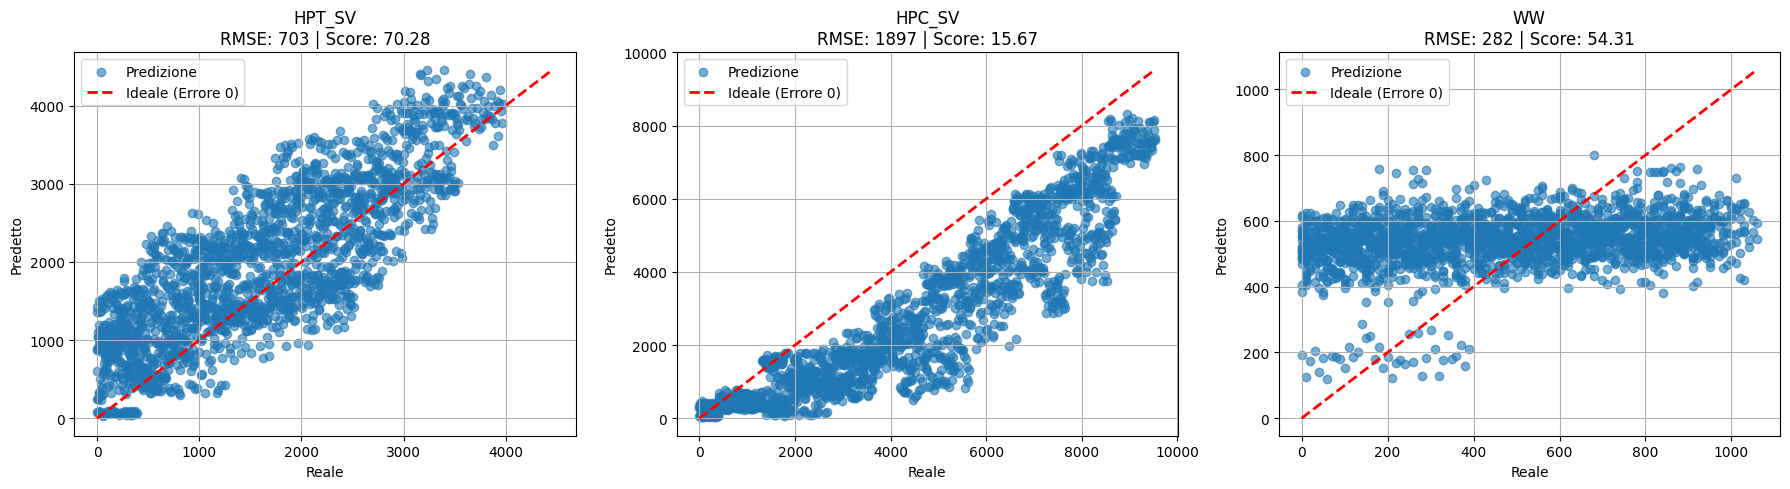

In [11]:
#in questo esempio usiamo il training set come train e validation


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ==============================================================================
# 1. FUNZIONI DI PREPROCESSING
# ==============================================================================
def process_dataset(df):
    """Aggrega i dati per volo (Cruise Only)."""
    if 'Sensed_Altitude' in df.columns:
        df = df[df['Sensed_Altitude'] > 20000].copy()
    
    # Identifica colonne presenti
    sensor_cols = [c for c in df.columns if 'Sensed_' in c]
    meta_cols = [c for c in ['Cumulative_WWs', 'Cumulative_HPC_SVs', 'Cumulative_HPT_SVs'] if c in df.columns]
    target_cols = [c for c in ['Cycles_to_HPC_SV', 'Cycles_to_HPT_SV', 'Cycles_to_WW'] if c in df.columns]

    agg_dict = {}
    for col in sensor_cols: agg_dict[col] = 'mean'
    for col in meta_cols: agg_dict[col] = 'max'
    for col in target_cols: agg_dict[col] = 'first'
    
    if 'ESN' in df.columns and 'Cycles_Since_New' in df.columns:
        return df.groupby(['ESN', 'Cycles_Since_New']).agg(agg_dict).reset_index()
    return pd.DataFrame()

# ==============================================================================
# 2. METRICA UFFICIALE
# ==============================================================================
def get_official_score(y_true, y_pred, component_type):
    error = y_pred - y_true
    alpha = 0.01
    max_val = np.max(y_true) if len(y_true) > 0 else 1
    beta = 1/float(max_val) if component_type == 'WW' else 2/float(max_val)
    
    weight = np.where(error >= 0, 2/(1+alpha*y_true), 1/(1+alpha*y_true))
    return np.mean(weight * (error ** 2) * beta)

# ==============================================================================
# 3. MAIN (CON SPLIT INTELLIGENTE)
# ==============================================================================
def main():
    print("--- 1. CARICAMENTO DATI ---")
    try:
        # Carichiamo SOLO il training set completo
        df_full = pd.read_csv('data/train/training_data.csv')
        print(f"Dataset completo caricato: {df_full.shape} righe")
    except FileNotFoundError:
        print("ERRORE: Non trovo 'data/train/training_data.csv'"); return

    # --- SPLIT MANUALE PER AVERE LA VERITÀ ---
    # Troviamo la lista dei motori disponibili
    all_engines = df_full['ESN'].unique()
    print(f"Motori disponibili: {all_engines}")
    
    # Usiamo l'ULTIMO motore come Validation (Test), tutti gli altri come Training
    val_engine_id = all_engines[-1] 
    train_engines = all_engines[:-1]
    
    print(f"\n--- CONFIGURAZIONE SPLIT ---")
    print(f"TRAINING su motori: {train_engines}")
    print(f"VALIDATION (Test) su motore: {val_engine_id}")
    print("(Uso questo motore per calcolare l'errore perché di lui ho le risposte!)")

    # Dividiamo il dataset grezzo
    df_train_raw = df_full[df_full['ESN'].isin(train_engines)]
    df_val_raw = df_full[df_full['ESN'] == val_engine_id]

    # --- 2. PREPROCESSING ---
    print("\n--- 2. PREPROCESSING ---")
    df_train = process_dataset(df_train_raw)
    df_val = process_dataset(df_val_raw)

    # --- 3. DEFINIZIONE FEATURE ---
    features = [c for c in df_train.columns if 'Sensed_' in c or 'Cumulative_' in c]
    X_train = df_train[features]
    X_val = df_val[features]

    # --- 4. ADDESTRAMENTO E CALCOLO ERRORE ---
    print("\n--- 3. ADDESTRAMENTO E RISULTATI ---")
    targets = ['Cycles_to_HPT_SV', 'Cycles_to_HPC_SV', 'Cycles_to_WW']
    results = {}

    for target in targets:
        if target not in df_train.columns: continue
        
        print(f"\nAnalisi Target: {target}")
        
        # Training
        model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
        model.fit(X_train, df_train[target])
        
        # Prediction
        y_pred = model.predict(X_val)
        y_true = df_val[target] # Qui ESISTE perché viene dal training split!
        
        # Calcolo Errori
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        comp_type = 'WW' if 'WW' in target else ('HPC' if 'HPC' in target else 'HPT')
        score = get_official_score(y_true.values, y_pred, comp_type)
        
        print(f"   -> RMSE (Errore Medio): {rmse:.2f} cicli")
        print(f"   -> SCORE PHM (Punteggio Gara): {score:.4f}")
        
        results[target] = {'true': y_true, 'pred': y_pred, 'rmse': rmse, 'score': score}

    # --- 5. GRAFICI ---
    print("\n--- 4. GENERAZIONE GRAFICI ---")
    if results:
        fig, axes = plt.subplots(1, len(results), figsize=(6 * len(results), 5))
        if len(results) == 1: axes = [axes]
        
        for i, (target, res) in enumerate(results.items()):
            ax = axes[i]
            # Plot Punti
            ax.scatter(res['true'], res['pred'], alpha=0.6, label='Predizione')
            # Plot Linea Ideale Rossa
            min_v = min(res['true'].min(), res['pred'].min())
            max_v = max(res['true'].max(), res['pred'].max())
            ax.plot([min_v, max_v], [min_v, max_v], 'r--', lw=2, label='Ideale (Errore 0)')
            
            clean_name = target.replace('Cycles_to_', '')
            ax.set_title(f"{clean_name}\nRMSE: {res['rmse']:.0f} | Score: {res['score']:.2f}")
            ax.set_xlabel('Reale')
            ax.set_ylabel('Predetto')
            ax.legend()
            ax.grid(True)
            
        plt.tight_layout()
        plt.savefig('error_analysis.png')
        print("Grafico salvato come 'error_analysis.png'")
        plt.show()

if __name__ == "__main__":
    main()